In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
# Loaded a set of images
root_dir = "training/"
image_dir = root_dir + "images/"
gt_dir = root_dir + "groundtruth/"

In [3]:
files = os.listdir(image_dir)

In [4]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [5]:
imgs = [load_image(image_dir + files[i]) for i in range(len(files))]
print(files[0])

gt_imgs = [load_image(gt_dir + files[i]) for i in range(len(files))]
print(files[0])

satImage_001.png
satImage_001.png


In [6]:
# Extract patches from input images
patch_size = 32 # each patch is 16*16 pixels
step = 16

In [36]:
np.arange(0, 13, 3)

array([ 0,  3,  6,  9, 12])

In [46]:
def img_crop_overlapping(img, patch_w, patch_h, step):
    list_patches = []
    is_2d = len(img.shape) < 3
    
    # img is NxN - rectangular,  hence N = img.shape[0] = img.shape[1]
    # we also suppose that patch_w = patch_h
   
    N = img.shape[1]
    
    for i in np.arange(0, N, step):
        for j in np.arange(0, N, step):
            if is_2d:
                im_patch = img[j:j+patch_w, i:i+patch_h]
            else:
                im_patch = img[j:j+patch_w, i:i+patch_h, :]
            list_patches.append(im_patch)
    return list_patches

In [9]:
# every row contains 400-step/patch_w-step -> 400-16/16 = 24 patches per row
# and we have 24 rows

In [47]:
img_ow_patches_32 = [img_crop_overlapping(imgs[i], patch_size, patch_size, step) for i in range(len(imgs))]
gt_ow_patches_32 = [img_crop_overlapping(gt_imgs[i], patch_size, patch_size, step) for i in range(len(gt_imgs))]

In [48]:
# Linearize list of patches: every image contains 600 patches; 
# we put a sequence of patches consequently for every image into np.array

img_patches = [img_ow_patches_32[i][j] 
               for i in range(len(img_ow_patches_32)) for j in range(len(img_ow_patches_32[i]))]
gt_patches =  [gt_ow_patches_32[i][j] 
               for i in range(len(gt_ow_patches_32)) for j in range(len(gt_ow_patches_32[i]))]

In [12]:
foreground_threshold = 0.25

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

In [13]:
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

In [49]:
_X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
_Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [41]:
_X[0]

array([ 0.18764409,  0.20233871,  0.16657333,  0.01774854,  0.01656516,
        0.01445996], dtype=float32)

In [16]:
# no randomness: sequential indices
def build_k_indices(N, k_fold):
    interval = int(N/k_fold)
    indices = np.arange(N)

    k_indices = None
    if N%k_fold == 0:
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    else:
        k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
        k_indices.append(indices[(k_fold-1)*interval : N])
    return np.array(k_indices)

In [17]:
from metrics import *

In [18]:
def cross_validation(X, Y, k_indices, k, model):
    
    testing_im = X[k_indices[k]].tolist()
    testing_gt = Y[k_indices[k]].tolist()
    
    training_im = []
    training_gt = []
    for j in range(len(k_indices)):
        if j != k:
            training_im += X[k_indices[j]].tolist()
            training_gt += Y[k_indices[j]].tolist()

    model.fit(training_im, training_gt)
    prediction = model.predict(testing_im)
    
    #TODO: refactor
    testing_gt = np.array(testing_gt)
    fp = calc_fp(prediction, testing_gt)
    fn = calc_fn(prediction, testing_gt)
    tp = calc_tp(prediction, testing_gt)
    
    print(fp, tp, fn)
    r = recall(tp, fn)
    p = precision(tp, fp)
    score = f_mean(p, r)
    
    return r, p, score

In [19]:
def cross_validation_demo(model):
    k_fold = 4
    
    k_indices = build_k_indices(len(img_patches), k_fold)

    res = []
    for k in range(k_fold):
        res.append(cross_validation(_X, _Y, k_indices, k, model))
    return res

In [20]:
from sklearn import linear_model

In [50]:
model = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
Z = cross_validation_demo(model)
Z

5629 3425 1051
4637 3426 1324
4773 3660 1481
4230 3320 1600


[(0.7651921358355674, 0.37828584051248065, 0.5062823355506282),
 (0.7212631578947368, 0.42490388192980283, 0.5347693748536643),
 (0.7119237502431434, 0.4340092493774457, 0.5392662442905555),
 (0.6747967479674797, 0.43973509933774835, 0.5324779470729751)]

In [23]:
# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop_overlapping(img, patch_size, patch_size, step)
    X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

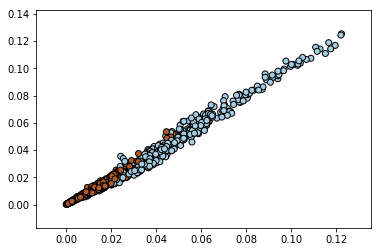

In [51]:
# Run prediction on the img_idx-th image
img_idx = 12

image_dir = "test_set_images/"  + "test_" + str(img_idx) +"/"
file = os.listdir(image_dir)[0]
Xi = extract_img_features(image_dir+file)

Zi = model.predict(Xi)
plt.scatter(Xi[:, 4], Xi[:, 5], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

In [25]:
test_dir = './testing/groundtruth/'
test_overlay_dir = './testing/overlay/'

In [ ]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

In [52]:
image_dir = "./test_set_images/"  + "test_" + str(1) +"/"
file = os.listdir(image_dir)[0]
Xi = extract_img_features(image_dir+file)
Zi = model.predict(Xi)

In [69]:
tmp = load_image(image_dir+file)
tmp.shape[0]

608

In [67]:
Zi.shape, Xi.shape

((1444,), (1444, 6))

In [100]:
def labels_to_img(ov_labels, im_w, im_h, step):
    
    labels_per_raw = int(im_w/step)
    label_per_column = int(im_h/step)
    
    N = len(ov_labels)
    
    im = np.zeros([im_w, im_h])
    im_i = step
    im_j = step
    
    for i in range(labels_per_raw-1):
        for j in range(label_per_column-1):
            neigh_labels = []
            
            if i*labels_per_raw + j < N:
                neigh_labels.append(ov_labels[i*labels_per_raw + j])
                
            if i*labels_per_raw + j + 1 < N:
                neigh_labels.append(ov_labels[i*labels_per_raw + j + 1])#right-up
                
            if (i+1)*labels_per_raw + j < N:
                neigh_labels.append(ov_labels[(i+1)*labels_per_raw + j])#left-bottom
                
            if (i+1)*labels_per_raw + j + 1 < N:
                neigh_labels.append(ov_labels[(i+1)*labels_per_raw + j + 1])#right-bottom
            
            _mean = np.mean(neigh_labels)
            _label = value_to_class(_mean)
            
            print((im_i, im_i + step-1), (im_j, im_j + step-1))
            im[im_i: im_i + step, im_j: im_j + step] = _label
            
            im_j +=step

        im_j = step
        im_i += step
    return im

In [101]:
im_ = labels_to_img(Zi, 608, 608, 16)

(16, 31) (16, 31)
(16, 31) (32, 47)
(16, 31) (48, 63)
(16, 31) (64, 79)
(16, 31) (80, 95)
(16, 31) (96, 111)
(16, 31) (112, 127)
(16, 31) (128, 143)
(16, 31) (144, 159)
(16, 31) (160, 175)
(16, 31) (176, 191)
(16, 31) (192, 207)
(16, 31) (208, 223)
(16, 31) (224, 239)
(16, 31) (240, 255)
(16, 31) (256, 271)
(16, 31) (272, 287)
(16, 31) (288, 303)
(16, 31) (304, 319)
(16, 31) (320, 335)
(16, 31) (336, 351)
(16, 31) (352, 367)
(16, 31) (368, 383)
(16, 31) (384, 399)
(16, 31) (400, 415)
(16, 31) (416, 431)
(16, 31) (432, 447)
(16, 31) (448, 463)
(16, 31) (464, 479)
(16, 31) (480, 495)
(16, 31) (496, 511)
(16, 31) (512, 527)
(16, 31) (528, 543)
(16, 31) (544, 559)
(16, 31) (560, 575)
(16, 31) (576, 591)
(16, 31) (592, 607)
(32, 47) (16, 31)
(32, 47) (32, 47)
(32, 47) (48, 63)
(32, 47) (64, 79)
(32, 47) (80, 95)
(32, 47) (96, 111)
(32, 47) (112, 127)
(32, 47) (128, 143)
(32, 47) (144, 159)
(32, 47) (160, 175)
(32, 47) (176, 191)
(32, 47) (192, 207)
(32, 47) (208, 223)
(32, 47) (224, 239)
(3

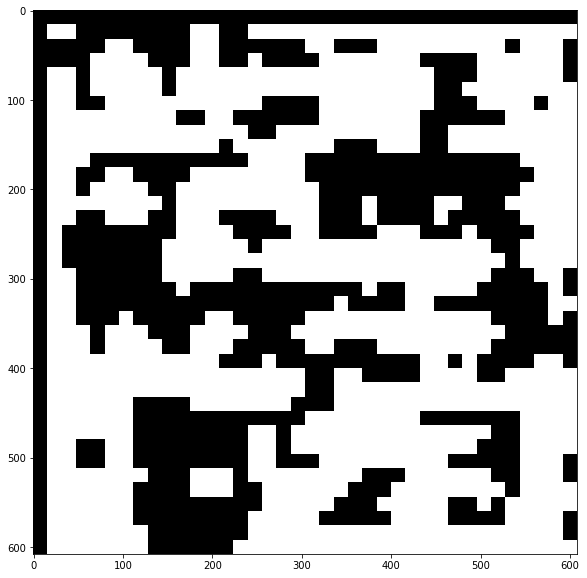

In [102]:
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(im_, cmap='Greys_r')

In [ ]:
for i in range(1,51):
    image_dir = "./test_set_images/"  + "test_" + str(i) +"/"
    file = os.listdir(image_dir)[0]
    Xi = extract_img_features(image_dir+file)
    Zi = model.predict(Xi)

    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)

    img = load_image("./test_set_images/"  + "test_" + str(i) +"/test_{0}.png".format(i))
    new_img = make_img_overlay(img, predicted_im)
    
    img_file_name = test_dir + 'satImage_' + '%.3d'%i + '.png'
    img_overlay_name = test_overlay_dir + 'satImage_' + '%.3d'%i + '.png'
    scipy.misc.imsave(img_overlay_name, new_img)
    scipy.misc.imsave(img_file_name, predicted_im)